In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS' 

In [39]:
df.head() 

,Production
Date,
1962-01-01,340
1962-02-01,201
1962-03-01,147
1962-04-01,125
1962-05-01,150


<Axes: xlabel='Date'>

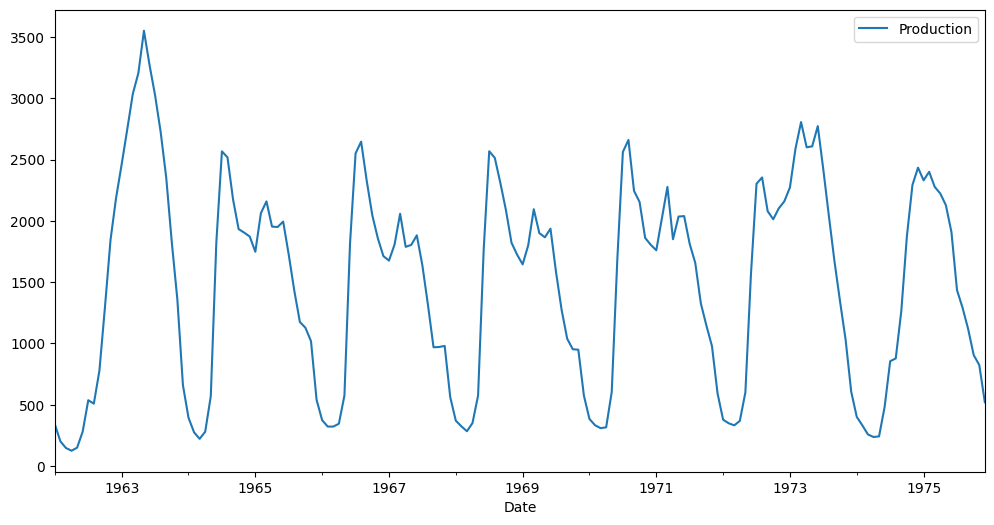

In [40]:
df.plot(figsize=(12,6)) #trend of data

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose #mention statsmodel as a library

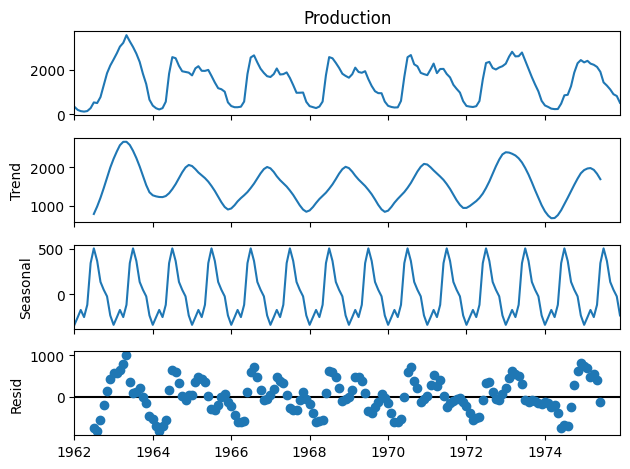

In [43]:
results = seasonal_decompose(df['Production'])
results.plot();
#Graph above is compressed to a smaller scale
#Trend removes the seasonal pattern
#Seasonal subtracts and remove trend from original graph
#Residual is the noise part, cannot explain the sections in the graph

In [44]:
len(df) #length of dataset

168

In [ ]:
train = df.iloc[:156] #use the last 10 months as a training set by subtracting 168 with 156
test = df.iloc[156:]

In [46]:
from sklearn.preprocessing import MinMaxScaler #pip install scikit-learn
scaler = MinMaxScaler()

In [49]:
df.head(),df.tail() #Prints the first and last half of the dataset

(            Production
 Date                  
 1962-01-01         340
 1962-02-01         201
 1962-03-01         147
 1962-04-01         125
 1962-05-01         150,
             Production
 Date                  
 1975-08-01        1291
 1975-09-01        1118
 1975-10-01         905
 1975-11-01         824
 1975-12-01         520)

In [51]:
scaler.fit(train) #Calculates minimum value, maximum value and standard deviation
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [52]:
scaled_train[:10] 

array([[0.0627554 ],
       [0.0221833 ],
       [0.00642148],
       [0.        ],
       [0.00729714],
       [0.04553415],
       [0.12025686],
       [0.11208406],
       [0.1903094 ],
       [0.3420899 ]])

In [53]:
from keras.preprocessing.sequence import TimeseriesGenerator #pip install tensorflow

In [54]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [55]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.0627554  0.0221833  0.00642148]
Predict this y: 
 [[0.]]


In [56]:
X.shape

(1, 3, 1)

In [57]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [59]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 4ms/step - loss: 0.0686
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0329
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0217
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 5/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0141
Epoch 7/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0122
Epoch 8/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0114
Epoch 9/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0110
Epoch 10/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0109
Epoch 11/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 12/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 13/50
144/144 [====

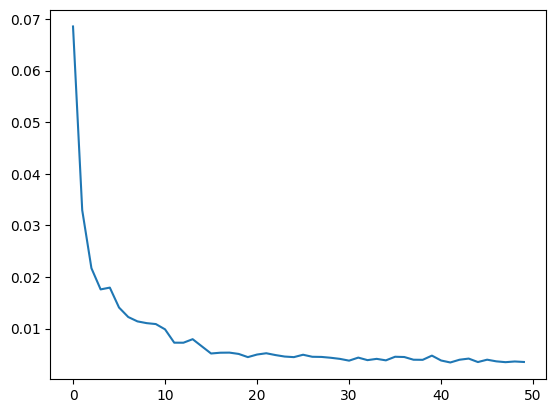

In [65]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [66]:
last_train_batch = scaled_train[-12:]

In [67]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [68]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 162ms/step


array([[0.6497217]], dtype=float32)

In [69]:
scaled_test[0]

array([0.64389959])

In [72]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [73]:
test_predictions

[array([0.6497217], dtype=float32),
 array([0.63667417], dtype=float32),
 array([0.6399018], dtype=float32),
 array([0.625419], dtype=float32),
 array([0.58710766], dtype=float32),
 array([0.5192005], dtype=float32),
 array([0.4338148], dtype=float32),
 array([0.35045925], dtype=float32),
 array([0.26621425], dtype=float32),
 array([0.17894337], dtype=float32),
 array([0.09689757], dtype=float32),
 array([0.029142], dtype=float32)]

In [74]:
test.head()

,Production
Date,
1975-01-01,2331
1975-02-01,2400
1975-03-01,2277
1975-04-01,2223
1975-05-01,2128


In [75]:
true_predictions = scaler.inverse_transform(test_predictions)

In [79]:
test['Predictions'] = true_predictions

C:\Users\ivanne bayer\AppData\Local\Temp\ipykernel_29132\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

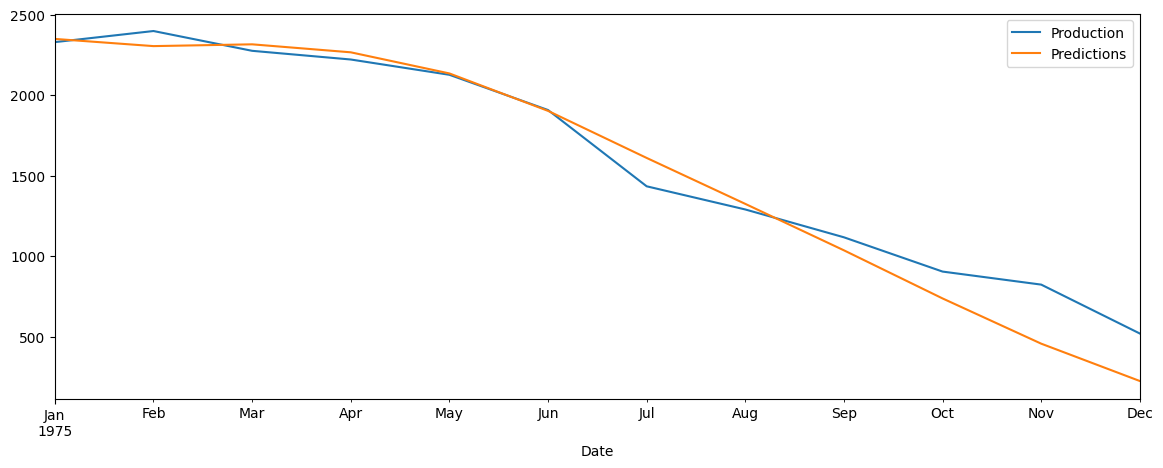

In [77]:
test.plot(figsize=(14,5))

In [80]:
from sklearn.metrics import mean_squared_error #tries to calculate how accurate it is compared to the original graph
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

158.4888526370603


In [ ]:
#ARIMA CALCULATIONS BEFORE FOR COMPARING
import pandas as pd
df=pd.read_csv('/content/MaunaLoaDailyTemps.csv',index_col='DATE'   ,parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()
df